In [56]:
import numpy as np
import pandas as pd
from gnews import GNews
import yfinance as yf
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

In [48]:
def extract_economic_news(language='fr', max_results=50, period='7d', topic='ECONOMY'):
    google_news = GNews(language=language, max_results=max_results, period=period)
    news = google_news.get_news_by_topic(topic)
    title_news = [article['title'] for article in news]
    return news,title_news

In [ ]:
french_economy, french_title = extract_economic_news()
german_economy, german_title = extract_economic_news(language='de')

Prix des carburants : six questions sur une hausse qui fait polémique - Les Echos


In [41]:
df_oat = pd.read_csv("Rendement de l'Obligation France 10 ans - Données Historiques (1).csv")
df_bund = pd.read_csv("Rendement de l'Obligation Allemagne 10 ans - Données Historiques.csv")

In [70]:
def align_with_index(df1, df2, date_col='Date', join_type='inner'):
    """
    Align datasets using pandas align method.
    join_type: 'inner', 'outer', 'left', 'right'
    """
    # Set date as index
    df1_indexed = df1.set_index(date_col)
    df2_indexed = df2.set_index(date_col)
    
    # Align the dataframes
    df1_aligned, df2_aligned = df1_indexed.align(df2_indexed, join=join_type, axis=0)
    
    return df1_aligned.reset_index(), df2_aligned.reset_index()
df_oat_aligned, df_bund_aligned = align_with_index(df_oat, df_bund, date_col='Date', join_type='inner')
df_oat_aligned['Dernier'] = df_oat_aligned['Dernier'].str.replace(',', '.').astype(float)
df_bund_aligned['Dernier'] = df_bund_aligned['Dernier'].str.replace(',', '.').astype(float)

df_oat_aligned['Date'] = pd.to_datetime(df_oat_aligned['Date'], format='%d/%m/%Y')
df_bund_aligned['Date'] = pd.to_datetime(df_bund_aligned['Date'], format='%d/%m/%Y')

In [65]:
y = df_oat_aligned['Dernier']/df_bund_aligned['Dernier']

In [58]:
y

array([nan, nan, nan, ..., nan, nan, nan], shape=(1318,))

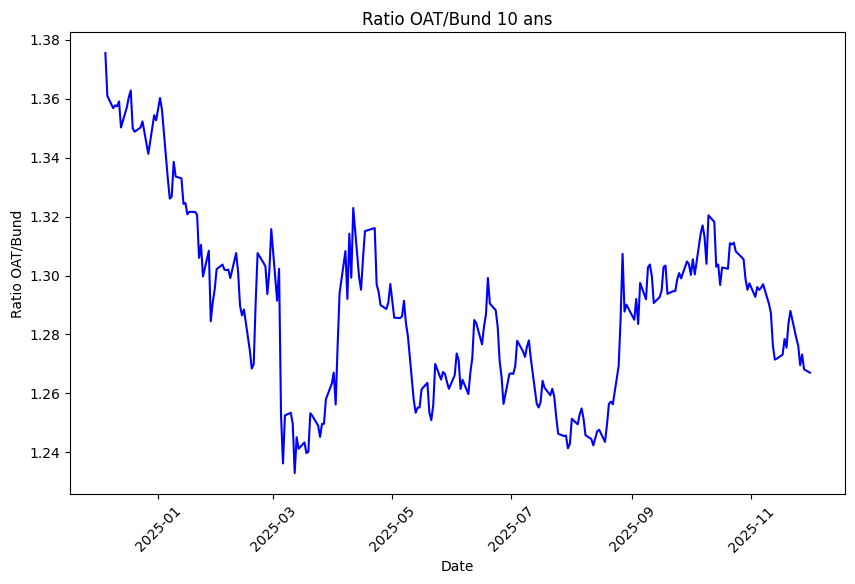

In [80]:
numbers_of_points = 252
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_oat_aligned['Date'][:numbers_of_points], y[:numbers_of_points], label='Ratio OAT/Bund 10 ans', color='blue')
ax.set_title("Ratio OAT/Bund 10 ans")
ax.set_xlabel("Date")
ax.set_ylabel("Ratio OAT/Bund")
plt.xticks(rotation=45)
plt.show()

In [81]:
#import adf test
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(y[:numbers_of_points])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: -1.1242878875383038
p-value: 0.7052896405659391


In [82]:
spread_one_year = y[:numbers_of_points]
spread_one_year_diff = spread_one_year.diff().dropna()

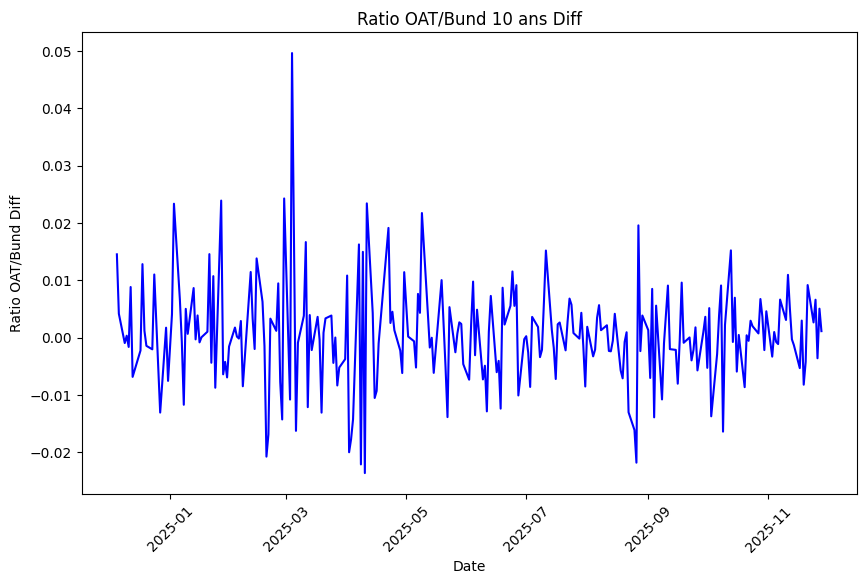

In [83]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_oat_aligned['Date'][1:numbers_of_points], spread_one_year_diff, label='Ratio OAT/Bund 10 ans Diff', color='blue')
ax.set_title("Ratio OAT/Bund 10 ans Diff")
ax.set_xlabel("Date")
ax.set_ylabel("Ratio OAT/Bund Diff")
plt.xticks(rotation=45)
plt.show()

In [84]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(spread_one_year_diff)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: -6.6580510123087375
p-value: 4.926735330871125e-09


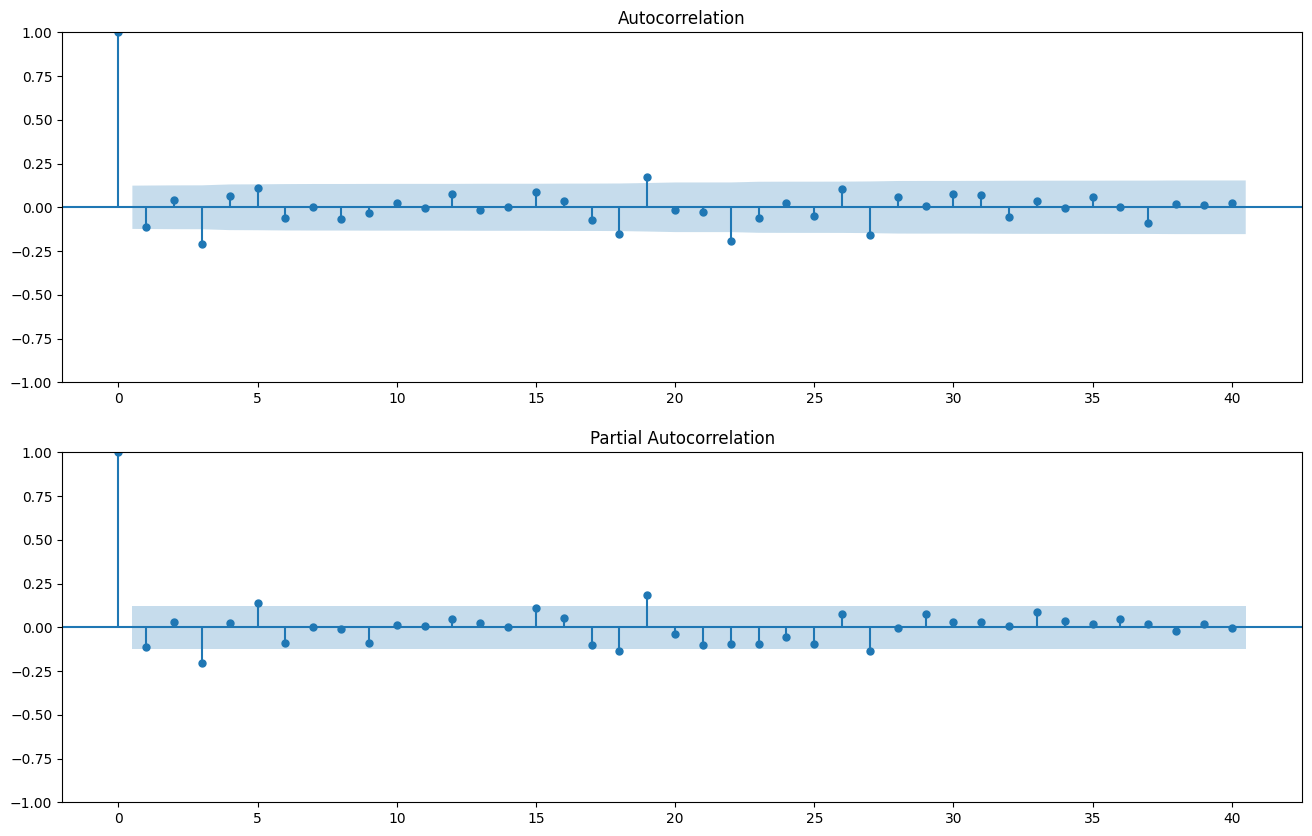

In [85]:
#Plotting pcf and acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2,1, figsize=(16,10))
plot_acf(spread_one_year_diff, ax=ax[0], lags=40)
plot_pacf(spread_one_year_diff, ax=ax[1], lags=40)
plt.show()

In [86]:
# p = 3, q=3
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(spread_one_year, order=(3,1,3))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Dernier   No. Observations:                  252
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 839.882
Date:                Tue, 02 Dec 2025   AIC                          -1665.764
Time:                        10:53:40   BIC                          -1641.086
Sample:                             0   HQIC                         -1655.833
                                - 252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3990      0.254     -1.568      0.117      -0.898       0.100
ar.L2         -0.4415      0.252     -1.751      0.080      -0.936       0.053
ar.L3         -0.1012      0.223     -0.453      0.6